In [35]:
import numpy as np
import importlib
import util as uti
import matplotlib.pyplot as plt
importlib.reload(uti)

# import math lib
from math import pi

# import Qiskit
from qiskit import Aer, IBMQ, execute, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.circuit.library import GroverOperator

# import basic plot tools
#import qiskit.visualization as vis
from qiskit.visualization import plot_histogram
%matplotlib inline

# input data

In [2]:
train1 = np.array([0.8, 0.2])
train2 = np.array([0.1, 0.9])
test = np.array([0.2, 0.8])

# quantum k-means with swap test

In [3]:
def calc_amplitudes(v):
    norm = np.linalg.norm(v)
    return v/norm

## swap test

In [4]:
# routine that expresses overlap of v1 and v2
def swap_test(v1_amp, v2_amp, draw=False):
    
    backend = Aer.get_backend('qasm_simulator')
    # create Quantum Register called "qr" with 5 qubits (default state 0)
    qr = QuantumRegister(5, name="qr")
    # create Classical Register called "cr" with 5 bits
    cr = ClassicalRegister(1, name="cr")
    # Creating Quantum Circuit called "qc" involving your Quantum Register "qr"
    # and your Classical Register "cr"
    qc = QuantumCircuit(qr, cr, name="swap_test")
    
    # load data
    qc.initialize(v1_amp, 1)
    # second qubit stays in |0> because second vector has only 1 qubit and the other is padding
    qc.initialize(v2_amp, qr[3:5])
    #qc.initialize(v2_amp[2:3], 4)
    
    # build swap test
    qc.h(qr[0])
    qc.cswap(qr[0], qr[1], qr[3])
    qc.cswap(qr[0], qr[2], qr[4])
    qc.h(qr[0])
    
    # measure
    qc.measure(qr[0], cr[0])
    if draw:
        qc.draw()
        
    shots=1024    
    job = execute(qc, backend=backend, shots=shots)
#   print( result.get_data(qc))
    counts = job.result().get_counts()
    print(counts)
    return ((counts['0']/shots) - 0.5)*2

In [30]:
def quantum_state_init(v1, v2):
    v1_norm = np.linalg.norm(v1)
    v2_norm = np.linalg.norm(v2)
    Z = v1_norm**2 + v2_norm**2
    q1_state = np.array([v1_norm, v2_norm]) * (1/np.sqrt(Z))
    q2_state = np.hstack([calc_amplitudes(v1), calc_amplitudes(v2)]) * (1/np.sqrt(2))
    return (q1_state, q2_state, Z)

In [31]:
def calc_dist(overlap, Z):
    return 2*Z*np.abs(overlap)**2

In [45]:
def create_cluster_oracle_1qb(qc, cluster_winner):
# if cluster idx == 0, make matrix [-1 0; 0 1], which corresponds to gate sequence XZX
    if cluster_winner == 0:
        qc.x(0)
        qc.z(0)
        #qc.x(0)
        return qc
    # if cluster idx == 1, make matrix [1 0; 0 -1], which corresponds to gate Z
    elif cluster_winner == 1:
        qc.z(0)
        return qc

In [ ]:
def create_cluster_oracle_2qb(qc, qr, cluster_winner):
    pass

In [2]:
# create oracle that flips amplitude of qubit corresponding to cluster number cluster_winner
def create_cluster_oracle(qc, qr, cluster_winner):
    if len(qr) == 1:
        return create_cluster_oracle_1qb(qc, cluster_winner)
    elif len(qr) == 2:
        return create_cluster_oracle_2qb(qc, qr, cluster_winner)
    else:
        print('oracles only implemented for 1 and 2 qubit systems')

In [33]:
# create combined oracle for grover search
def create_combined_oracle(distances):
    # would actually be delta(distances[0]-1) * create_cluster_oracle(0) + delta(distances[1]-1) * create_cluster_oracle(1)
    # to pick right oracle, but here looking directly at it
    if distances[0]:
        return create_cluster_oracle(0)
    else:
        return create_cluster_oracle(1)

In [13]:
def inversion_around_mean(qc, qr):
    # transform |s> back to |0> with hadamard gate (since |s> = H|0>)
    qc.h(qr)
    # add negative phase to all states orthogonal to |0> (which corresponds to inverting |1>) by [1 0; 0 -1], i.e. the Z gate 
    qc.z(qr)
    # transform back to |s>
    qc.h(qr)

In [35]:
# only need to pass in oracle, no inputs, since algo is applied to all possible inputs at once in any case
def grover_search(oracle, qubits_n=2):
    grover_circuit = QuantumCircuit(qubits_n)
    # initialize all qubits to uniform amplitudes by applying Hadamard gate
    for q in range(qubits_n):
        qc.h(q)
    

In [50]:
def closest_cluster_idx_circuit(cluster_winner):
    oracle = QuantumCircuit(1)
    create_cluster_oracle_1qb(oracle, cluster_winner)
    grover_op = GroverOperator(oracle, insert_barriers=True)
    return grover_op

In [52]:
cluster_winner = 0
grover_op = closest_cluster_idx_circuit(cluster_winner)

In [53]:
# get state vector after grover search
backend = Aer.get_backend('statevector_simulator')
qobj = assemble(grover_op)
result = backend.run(qobj).result()
statevec = result.get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

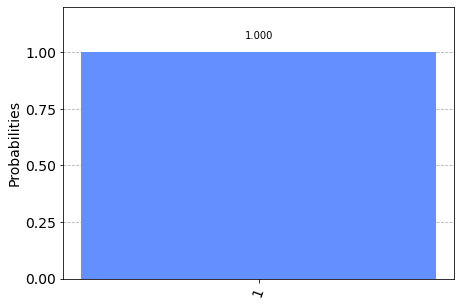

In [54]:
# run actual experiment and measure output
grover_op.measure_all()

qasm_sim = Aer.get_backend('qasm_simulator')
qobj = assemble(grover_op)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

In [48]:
cluster_winner = 1
oracle = QuantumCircuit(1)
create_cluster_oracle_1qb(oracle, cluster_winner)
grover_op = GroverOperator(oracle, insert_barriers=True)
grover_op.draw()

global phase: π
         ┌───┐ ░ ┌───┐ ░ ┌───┐┌───┐┌───┐ ░ ┌───┐
state_0: ┤ Z ├─░─┤ H ├─░─┤ X ├┤ Z ├┤ X ├─░─┤ H ├
         └───┘ ░ └───┘ ░ └───┘└───┘└───┘ ░ └───┘

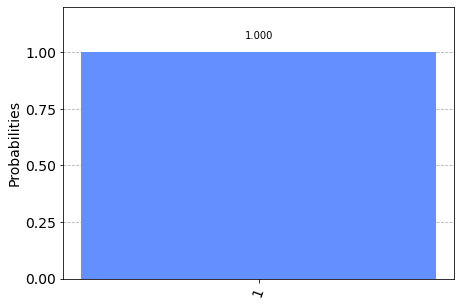

In [49]:
grover_op.measure_all()

qasm_sim = Aer.get_backend('qasm_simulator')
qobj = assemble(grover_op)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

In [33]:
# do grover search on 1 qubit system (2 cluster)
cluster_winner = 0
qr = QuantumRegister(1, name="qr") # 1 qubit |0> state
qc = QuantumCircuit(qr, name="grover_search")
# apply hadamard gate to get equal amplitues for cluster 1 and 2
qc.h(qr)
qc.barrier()
# apply quantum oracle
create_cluster_oracle(qc, cluster_winner)
qc.barrier()
# reflection around mean
inversion_around_mean(qc, qr)
qc.barrier()
# apply hadamard gate to get equal amplitues for cluster 1 and 2
qc.h(qr)
qc.draw()

┌───┐ ░ ┌───┐┌───┐┌───┐ ░ ┌───┐┌───┐┌───┐ ░ ┌───┐
qr_0: ┤ H ├─░─┤ X ├┤ Z ├┤ X ├─░─┤ X ├┤ Z ├┤ X ├─░─┤ H ├
      └───┘ ░ └───┘└───┘└───┘ ░ └───┘└───┘└───┘ ░ └───┘

In [34]:
# run the circuit and output result state vector
backend = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
result = backend.run(qobj).result()
statevec = result.get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

In [31]:
# run the circuit and output result state vector
backend = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
result = backend.run(qobj).result()
statevec = result.get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")

<IPython.core.display.Math object>

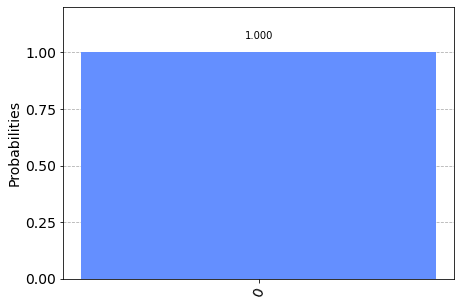

In [32]:
qc.measure_all()

qasm_sim = Aer.get_backend('qasm_simulator')
qobj = assemble(grover_op)
result = qasm_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

## calculate this in a loop k times to get k distances to the k clusters

In [20]:
# load/initialize two training vectors on qubits 2-3 and 4-5
q1_state, q2_state, Z = quantum_state_init(train1, train2)
print(q1_state)
print(q2_state)
overlap = swap_test(q1_state, q2_state, draw=True)

[0.67330033 0.7393691 ]
[0.68599434 0.17149859 0.07808688 0.70278193]
{'1': 351, '0': 673}


In [21]:
overlap

0.314453125

In [22]:
distance = calc_dist(overlap, Z)
distance

0.296642303466797

In [7]:
# build dummy circuit for drawing
# create Quantum Register called "qr" with 5 qubits
qr = QuantumRegister(5, name="qr")
# create Classical Register called "cr" with 5 bits
cr = ClassicalRegister(1, name="cr")
# Creating Quantum Circuit called "qc" involving your Quantum Register "qr"
# and your Classical Register "cr"
qc = QuantumCircuit(qr, cr, name="swap_test")

# load data
qc.initialize(q1_state, 1)
# second qubit stays in |0> because second vector has only 1 qubit and the other is padding
qc.initialize(q2_state, qr[3:5])
#qc.initialize(v2_amp[2:3], 4)
qc.barrier()

# build swap test
qc.h(qr[0])
qc.cswap(qr[0], qr[1], qr[3])
qc.cswap(qr[0], qr[2], qr[4])
qc.h(qr[0])

# measure
qc.measure(qr[0], cr[0])
qc.draw()


░ ┌───┐      ┌───┐┌─┐
qr_0: ─────────────────────────────────────────────────░─┤ H ├─■──■─┤ H ├┤M├
               ┌────────────────────────────┐          ░ └───┘ │  │ └───┘└╥┘
qr_1: ─────────┤ initialize(0.6733,0.73937) ├──────────░───────X──┼───────╫─
               └────────────────────────────┘          ░       │  │       ║ 
qr_2: ─────────────────────────────────────────────────░───────┼──X───────╫─
      ┌──────────────────────────────────────────────┐ ░       │  │       ║ 
qr_3: ┤0                                             ├─░───────X──┼───────╫─
      │  initialize(0.68599,0.1715,0.078087,0.70278) │ ░          │       ║ 
qr_4: ┤1                                             ├─░──────────X───────╫─
      └──────────────────────────────────────────────┘ ░                  ║ 
cr: 1/════════════════════════════════════════════════════════════════════╩═
                                                                          0